# Python - Week 6 - Day 2 - HW
## Shahin Mammadov

You will use the Pima Indian diabetes dataset. The dataset corresponds to a classification
problem on which you need to make predictions on the basis of whether a person is to suffer
diabetes given the 8 features in the dataset. You are asked to use this data to build a XGBoost
Classifier model using scikit-learn. Tune the parameters using Grid Search and Randomized Search
strategies.

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics
from xgboost import cv
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import itertools as it
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler    
import matplotlib.pyplot as mp
import seaborn as sb
from datetime import datetime
import time

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [2]:
data = pd.read_csv('diabetes.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
data[data.duplicated()]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [6]:
x_list = []

for x in data.columns[:len(data.columns)-1]:
    x_list.append(data[x])

In [7]:
X = pd.DataFrame(np.c_[x_list]).T
y = data['Outcome']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
X_test= st_x.transform(X_test) 

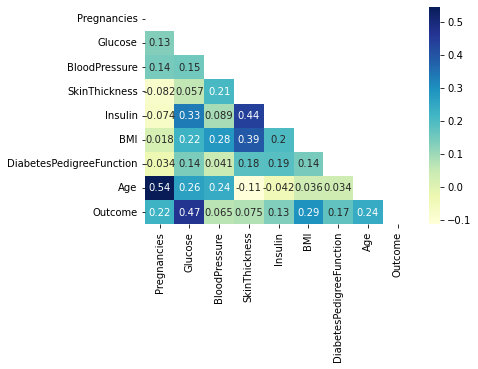

In [9]:
mask = np.triu(np.ones_like(data.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True, mask=mask)
 
# displaying heatmap
mp.show()

## XGBoost without parameter tuning

In [10]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
y_pred_xgb = XGB.predict(X_test)

In [11]:
metrics.accuracy_score(y_test, y_pred_xgb)

0.7705627705627706

In [12]:
metrics.confusion_matrix(y_test, y_pred_xgb)

array([[127,  20],
       [ 33,  51]], dtype=int64)

In [13]:
print(metrics.classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       147
           1       0.72      0.61      0.66        84

    accuracy                           0.77       231
   macro avg       0.76      0.74      0.74       231
weighted avg       0.77      0.77      0.77       231



## XGBoost with hyper parameter tuning with Grid Search

In [14]:
params = {
        'learning_rate': [0.1, 0.2, 0.4, 0.8, 1.5],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [15]:
xgb_grid = GridSearchCV(estimator=XGB, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1, return_train_score=True)

start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_grid_fit = xgb_grid.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 7 minutes and 40.97 seconds.


In [16]:
pd.DataFrame.from_dict(xgb_grid_fit.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_subsample,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.390069,0.164258,0.005855,0.000899,0.6,0.5,0.1,3,1,0.6,...,0.890014,0.890014,0.885673,0.875543,0.887120,0.872648,0.880058,0.881503,0.881366,0.006204
1,0.090594,0.017661,0.005104,0.000517,0.6,0.5,0.1,3,1,0.8,...,0.888567,0.884226,0.881331,0.874096,0.876990,0.882779,0.894509,0.881503,0.883535,0.005487
2,0.078202,0.014058,0.004766,0.000751,0.6,0.5,0.1,3,1,1.0,...,0.872648,0.882779,0.887120,0.874096,0.881331,0.879884,0.885838,0.874277,0.879919,0.004927
3,0.111740,0.022843,0.010568,0.006861,0.6,0.5,0.1,3,5,0.6,...,0.856729,0.843705,0.848046,0.849493,0.850941,0.843705,0.861272,0.845376,0.849391,0.005459
4,0.119988,0.025395,0.008631,0.008810,0.6,0.5,0.1,3,5,0.8,...,0.853835,0.863965,0.868307,0.853835,0.855282,0.865412,0.862717,0.868497,0.862702,0.005787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,0.183804,0.011076,0.007011,0.002088,1.0,5,1.5,5,5,0.8,...,0.907381,0.927641,0.914616,0.924747,0.914616,0.904486,0.930636,0.906069,0.916811,0.008664
2021,0.197408,0.014312,0.006485,0.001454,1.0,5,1.5,5,5,1.0,...,0.837916,0.861071,0.858177,0.833575,0.848046,0.835022,0.852601,0.874277,0.851704,0.012403
2022,0.130405,0.013257,0.006848,0.001247,1.0,5,1.5,5,10,0.6,...,0.840810,0.830680,0.827786,0.817656,0.824891,0.833575,0.822254,0.825145,0.828705,0.007029
2023,0.159421,0.015130,0.006683,0.001014,1.0,5,1.5,5,10,0.8,...,0.882779,0.856729,0.876990,0.890014,0.874096,0.863965,0.880058,0.861272,0.871239,0.010511


In [17]:
xgb_grid.best_params_

{'colsample_bytree': 0.6,
 'gamma': 5,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 0.6}

In [18]:
xgb_grid.best_score_

0.7773581681476418

In [19]:
params_empty = {}

In [20]:
xgb_grid_test = GridSearchCV(estimator=XGB, param_grid=params_empty, scoring='accuracy', cv=10, n_jobs=-1, return_train_score=True)

start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_grid_fit_test = xgb_grid_test.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 0.87 seconds.


In [21]:
xgb_grid_test.best_score_

0.7357142857142857

## XGBoost with hyper parameter tuning with Grid Search without CV

In [22]:
xgb_grid.best_params_

{'colsample_bytree': 0.6,
 'gamma': 5,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 0.6}

In [23]:
allNames = params
combinations = it.product(*(params[Name] for Name in allNames))
comb_params = list(combinations)

In [24]:
scores = []
start_time = timer(None) # timing starts from this point for "start_time" variable
for x in comb_params:
    XGB = XGBClassifier(learning_rate=x[0], min_child_weight=x[1], gamma=x[2], subsample=x[3], colsample_bytree=x[4], max_depth=x[5])
    XGB.fit(X_train, y_train)
    y_pred_xgb = XGB.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred_xgb))
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 2 minutes and 29.92 seconds.


In [25]:
max(scores)

0.8354978354978355

In [26]:
comb_params[scores.index(max(scores))]

(0.4, 1, 5, 1.0, 1.0, 4)

In [27]:
XGB_best = XGBClassifier(learning_rate=0.4, min_child_weight=1, gamma=5, subsample=0.8, colsample_bytree=0.8, max_depth=5)
XGB_best.fit(X_train, y_train)
y_pred_params = XGB_best.predict(X_test)

In [28]:
metrics.accuracy_score(y_test, y_pred_params)

0.7662337662337663

In [29]:
metrics.confusion_matrix(y_test, y_pred_params)

array([[131,  16],
       [ 38,  46]], dtype=int64)

In [30]:
print(metrics.classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       147
           1       0.70      0.62      0.66        84

    accuracy                           0.77       231
   macro avg       0.75      0.73      0.74       231
weighted avg       0.76      0.77      0.76       231



## XGBoost with hyper parameter tuning with Randomized Search

In [31]:
params = {
        'learning_rate': [0.1, 0.2, 0.4, 0.8, 1.5],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [32]:
XGBrs = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator=XGBrs,param_distributions=params,
                            scoring='accuracy',
                            cv=10,
                            n_iter=10,
                            return_train_score=True,
                            n_jobs=-1,)

start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_random_fit = xgb_random.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 2.52 seconds.


In [33]:
xgb_random_fit.best_params_

{'subsample': 1.0,
 'min_child_weight': 10,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 0.8}

In [34]:
xgb_random_fit.best_score_

0.764354066985646